In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

In [2]:
from __future__ import annotations

from glob import glob
import pickle

import matplotlib.pyplot as plt
import numpy as np

from voltplot import TIME_LABELS, TIME_TICKS, VoltPlot

from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

# hide top and right splines on plots
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [3]:
time_ticks =  [   0, 2400, 4800,  7200,  9600, 12000, 14400]
time_labels = ['0h', '4h', '8h', '12h', '16h', '20h', '24h']

v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
print(v_min, v_max)

y_min, y_max = 11.1, 13.4

129.96 158.76


In [4]:
# Recreate Fig8 in Qu and Li (2020)
# - they count the substation as bus 1
# - we count the substation as bus -1
index = [9, 19, 22, 31, 40, 46, 55]  # for us, we want to plot nodes [7, 17, etc.]

## Fig1 - Baselines
- voltage profile, no controller
- voltage profile, controller with true X
- voltage profile, Li et al. controller I
- voltage profile, Li et al. controller II

In [5]:
from network_utils import (
    create_56bus,
    create_RX_from_net,
    read_load_data)

net = create_56bus()
R, X = create_RX_from_net(net, noise=0)  # true R and X
p, qe = read_load_data()  # in MW and MVar
T, n = p.shape

v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

vpars = qe @ X + p @ R + v_sub  # shape [T, n]

vpars_nonlinear = np.load('nonlinear_voltage_baseline.npy')
vpars_nonlinear = (vpars_nonlinear*12.)**2

In [6]:
with open('out 2/CBCconst_20220211_052507.pkl', 'rb') as f:
    perf_ctrl = pickle.load(f)
    print(list(perf_ctrl.keys()))
with open('out 2/decentralized_feasible.pkl', 'rb') as f:
    li_ctrl_feas = pickle.load(f)
with open('out 2/decentralized_opt.pkl', 'rb') as f:
    li_ctrl_opt = pickle.load(f)

['vs', 'qcs', 'dists', 'params', 'elapsed', 'X_init']


In [7]:
path_adaptive = 'out/CBCproj_noise1.0_perm_norm1.0_seed7_partialobs_adaptive_20221128_095716.pkl'
path_adaptive_init = 'out/CBCproj_noise1.0_perm_norm1.0_seed7_partialobs_adaptive_true_initalization_20221218_135220.pkl'
path_fixed = 'out/CBCproj_noise1.0_perm_norm1.0_seed7_partialobs_fixed_20221126_220930.pkl'
with open(path_adaptive, 'rb') as f:
    data_adaptive = pickle.load(f)
with open(path_adaptive_init, 'rb') as f:
    data_adaptive_init = pickle.load(f)
with open(path_fixed, 'rb') as f:
    data_fixed = pickle.load(f)

In [8]:
data_adaptive['vs'][:,1].shape

(14421,)

In [9]:
print('max-voltage node:', np.argmax(vpars.max(axis=0)))
print('min-voltage node:', np.argmin(vpars.min(axis=0)))
print('max-voltage node:', np.argmax(vpars_nonlinear.max(axis=0)))
print('min-voltage node:', np.argmin(vpars_nonlinear.min(axis=0)))

max-voltage node: 17
min-voltage node: 35
max-voltage node: 18
min-voltage node: 36


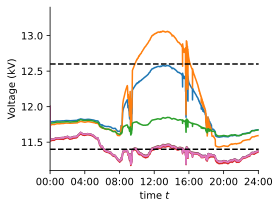

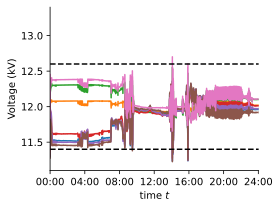

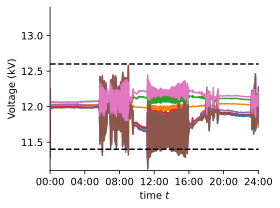

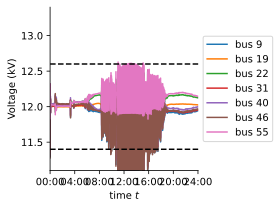

In [11]:
figs, axs = zip(*[
    plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    for _ in range(4)])

# axs[0].set_title('Voltage Profile, no Controller')
# axs[1].set_title('Voltage Profile, Robust Controller with $X^\star$')

ts = range(T)
for i in np.asarray(index) - 2:
    axs[0].plot(ts, np.sqrt(vpars_nonlinear[:, i]))
    axs[1].plot(ts, np.sqrt(data_adaptive['vs'][:, i]), label=f'bus {i+2}')
#     axs[1].plot(ts, np.sqrt(vpars[:, i]))
    axs[2].plot(ts, np.sqrt(data_adaptive_init['vs'][:, i]), label=f'bus {i+2}')
    axs[3].plot(ts, np.sqrt(data_fixed['vs'][:, i]), label=f'bus {i+2}')

for ax in axs:
    ax.set_xticks(TIME_TICKS)
    ax.set_xticklabels(TIME_LABELS)
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set(xlabel='time $t$', ylabel='Voltage (kV)')
    ax.set_ylim(y_min, y_max)
    ax.set_xlim(0, T)

for fig, tag in zip(figs, ['a', 'b', 'c', 'd']):    
    fig.savefig(f'out/non_baselines_{tag}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'out/non_baselines_{tag}.png', bbox_inches='tight', dpi=200, pad_inches=0)

leg = axs[3].legend(loc='center left', bbox_to_anchor=(1, 0.5))
figs[3].canvas.draw()
bbox = leg.get_window_extent().transformed(figs[3].dpi_scale_trans.inverted())
figs[3].savefig('out/non_baselines_legend.pdf', dpi=200, bbox_inches=bbox)

## Fig2 - Med-noise, Med-uncertainty
- ax1: voltage profile of a single node, many seeds
  - voltage profile of robust controller, no CBC
  - voltage profile of robust controller w/ CBC
- ax2: same thing, for a different bus
- ax3: CBC plots

In [ ]:
def plot_fill(ax, values, color, label, alpha=False):
    """
    Args
    - values: shape [T, n]
    - color: int, index into tab20 colors
        0 = blue, 2 = orange, 4 = green
    """
    T = values.shape[0]
    mean = values.mean(axis=1)
    std = values.std(axis=1)
    ts = range(T)
    dark = plt.cm.tab20.colors[color]
    light = plt.cm.tab20.colors[color + 1]
    ax.plot(ts, mean, color=dark, lw=0.5, label=label)
    if alpha:
        ax.fill_between(ts, mean-std, mean+std, color=light, alpha=0.5)
    else:
        ax.fill_between(ts, mean-std, mean+std, color=light)

In [ ]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

bus1 = 17
bus2 = 29

# collect controller-only voltage profiles
label = '$\Pi$, fixed $\hat{X}$'
ro_bus1 = np.zeros([T, 4])
ro_bus2 = np.zeros([T, 4])

paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out/CBCconst_noise0.5_perm_norm0.5*.pkl')))
assert len(paths) == 4
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].axhline(data['dists']['true'],
                   color=plt.cm.tab20.colors[0],
                   label=label if i == 0 else None)

plot_fill(ax=axs[0], values=ro_bus1, color=0, label=label)
plot_fill(ax=axs[1], values=ro_bus2, color=0, label=label)

# collect controller+cbc voltage profiles
label = '$\Pi$ + SEL'
rocbc_bus1 = np.zeros([T, 4])
rocbc_bus2 = np.zeros([T, 4])

for i, path in enumerate(glob('out/CBCproj_noise0.5_perm_norm0.5*.pkl')):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    rocbc_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    rocbc_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
                color=plt.cm.tab20.colors[2],
                label=label if i == 0 else None)
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||_\bigtriangleup$')

plot_fill(ax=axs[0], values=rocbc_bus1, color=2, label=label)
plot_fill(ax=axs[1], values=rocbc_bus2, color=2, label=label)

for ax in [axs[0], axs[1]]:
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set_ylabel('Voltage (kV)')
    ax.set_ylim(y_min, y_max)
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper left')
axs[2].legend()

for ax in axs:
    ax.set_xlim(0, T)
    ax.set(xticks=time_ticks, xticklabels=time_labels)
    # ax.set(xlabel='time $t$', xticks=TIME_TICKS, xticklabels=TIME_LABELS)

for i, fig in enumerate(figs):
    # fig.savefig(f'plots/med_med_{i}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'plots/acm_med_med_{i}.png', bbox_inches='tight', dpi=200, pad_inches=0)

# fig.suptitle('Medium Noise, Medium Uncertainty Set', y=1.05)

## Fig3 - large-noise, large-uncertainty
- ax1: voltage profile of a single node, many seeds
  - voltage profile of robust controller, no CBC
  - voltage profile of robust controller w/ CBC
- ax2: same thing, for a different bus
- ax3: CBC plots

In [ ]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

bus1 = 17
bus2 = 29

# collect controller-only voltage profiles
label = '$\Pi$, fixed $\hat{X}$'
ro_bus1 = np.zeros([T, 4])
ro_bus2 = np.zeros([T, 4])

paths = list(filter(
    lambda x: ('Pu' not in x) and ('partialobs' not in x),
    glob('out/CBCconst_noise1.0_perm_norm1.0*.pkl')))
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].axhline(data['dists']['true'],
                   color=plt.cm.tab20.colors[0],
                   label=label if i == 0 else None)

plot_fill(ax=axs[0], values=ro_bus1, color=0, label=label)
plot_fill(ax=axs[1], values=ro_bus2, color=0, label=label)

# collect controller+cbc voltage profiles
label = '$\Pi$ + SEL'
rocbc_bus1 = np.zeros([T, 4])
rocbc_bus2 = np.zeros([T, 4])

paths = list(filter(
    lambda x: 'partialobs' not in x,
    glob('out/CBCproj_noise1.0_perm_norm1.0*.pkl')))
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    rocbc_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    rocbc_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
                color=plt.cm.tab20.colors[2],
                label=label if i == 0 else None)
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||_\bigtriangleup$')

plot_fill(ax=axs[0], values=rocbc_bus1, color=2, label=label, alpha=True)
plot_fill(ax=axs[1], values=rocbc_bus2, color=2, label=label, alpha=True)

# collect controller+cbc (partialobs) voltage profiles
label = '$\Pi$ + SEL (p.o.)'
rocbc_partial_bus1 = np.zeros([T, 4])
rocbc_partial_bus2 = np.zeros([T, 4])

paths = list(filter(
    lambda x: 'partialobs' in x,
    glob('out/CBCproj_noise1.0_perm_norm1.0*.pkl')))
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    rocbc_partial_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    rocbc_partial_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]],
                color=plt.cm.tab20.colors[4], lw=1,
                label=label if i == 0 else None)

plot_fill(ax=axs[0], values=rocbc_partial_bus1, color=4, label=label, alpha=True)
plot_fill(ax=axs[1], values=rocbc_partial_bus2, color=4, label=label, alpha=True)

for ax in [axs[0], axs[1]]:
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set_ylabel('Voltage (kV)')
    ax.set_ylim(y_min, y_max)
axs[0].legend(loc='lower left')
axs[1].legend(loc='upper left')
axs[2].legend()

for ax in axs:
    ax.set_xticks(TIME_TICKS)
    ax.set_xticklabels(TIME_LABELS)
    ax.set_xlim(0, T)
    ax.set_xlabel('time $t$')

for i, fig in enumerate(figs):
    fig.savefig(f'plots/large_large_partial_{i}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'plots/large_large_partial_{i}.png', bbox_inches='tight', dpi=200, pad_inches=0)

In [ ]:
figs, axs = [], []
for i in range(3):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=60, tight_layout=True)
    figs.append(fig)
    axs.append(ax)

bus1 = 17
bus2 = 29

# collect controller-only voltage profiles
ro_bus1 = np.zeros([T, 4])
ro_bus2 = np.zeros([T, 4])

paths = list(filter(
    lambda x: 'Pu' not in x,
    glob('out/CBCconst_noise0.5_perm_norm0.5*.pkl')))
for i, path in enumerate(paths):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    ro_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    ro_bus2[:, i] = np.sqrt(data['vs'][:, bus2])

plot_fill(ax=axs[0], values=ro_bus1, color=0,
          label='$\Pi$, fixed $\hat{X}$')
plot_fill(ax=axs[1], values=ro_bus2, color=0,
          label='$\Pi$, fixed $\hat{X}$')

# collect controller+cbc voltage profiles
rocbc_bus1 = np.zeros([T, 4])
rocbc_bus2 = np.zeros([T, 4])

for i, path in enumerate(glob('out/CBCproj_noise0.5_perm_norminit0.5_norm1.0*.pkl')):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    rocbc_bus1[:, i] = np.sqrt(data['vs'][:, bus1])
    rocbc_bus2[:, i] = np.sqrt(data['vs'][:, bus2])
    axs[2].plot(data['dists']['t'] + [T], data['dists']['true'] + [data['dists']['true'][-1]], color='orange')
axs[2].set_ylabel(r'$||\hat{X}_t - X^\star||_\bigtriangleup$')

plot_fill(ax=axs[0], values=rocbc_bus1, color=2,
          label='$\Pi$ + SEL')
plot_fill(ax=axs[1], values=rocbc_bus2, color=2,
          label='$\Pi$ + SEL')

for ax in [axs[0], axs[1]]:
    ax.axhline(11.4, ls='--', color='black')
    ax.axhline(12.6, ls='--', color='black')
    ax.set_ylabel('Voltage (kV)')
    ax.set_ylim(y_min, y_max)
    ax.legend(loc='upper center')

for ax in axs:
    ax.set_xticks(TIME_TICKS)
    ax.set_xticklabels(TIME_LABELS)
    ax.set_xlim(0, T)
    ax.set_xlabel('time $t$')

for i, fig in enumerate(figs):
    fig.savefig(f'plots/mixed_{i}.pdf', bbox_inches='tight', dpi=200, pad_inches=0)
    fig.savefig(f'plots/mixed_{i}.png', bbox_inches='tight', dpi=200, pad_inches=0)

In [ ]:
for path in glob('out/CBCconst_2*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
for path in glob('out/CBCconst_noise0.4*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
for path in glob('out/CBCconst_noise0.8*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
for path in glob('out/CBCconst_noise1.0_*norm0.4*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
for path in glob('out/CBCconst_noise0.9*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
from network_utils import (
    create_56bus,
    create_RX_from_net,
    read_load_data
)

net = create_56bus()
R, X = create_RX_from_net(net, noise=0)  # true R and X
p, qe = read_load_data()  # in MW and MVar
T, n = p.shape

### FIXED PARAMETERS
v_min, v_max = (11.4**2, 12.6**2)  # +/-5%, units kV^2
v_nom = 12**2  # nominal squared voltage magnitude, units kV^2
v_sub = v_nom  # fixed squared voltage magnitude at substation, units kV^2

vpars = qe @ X + p @ R + v_sub  # shape [T, n]

In [ ]:
for path in glob('out/CBCconst_noise1.0_*norm1.*.pkl'):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())
    
    volt_plot = VoltPlot(v_lims=(11.4, 12.6), q_lims=(-0.24, 0.24))
    volt_plot.update(
        qcs=data['qcs'],
        vs=np.sqrt(data['vs']),
        vpars=np.sqrt(vpars),
        dists=(data['dists']['t'], data['dists']['true']))
    print(data['dists'])
    plt.show(volt_plot.fig)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5), tight_layout=True)
ax.scatter(np.arange(data['vs'].shape[0]), data['vs'][:,54], s=1)

In [ ]:
for path in sorted(glob('out/CBC*_perm*.pkl')):
    print(path)
    with open(path, 'rb') as f:
        data = pickle.load(f)
    vs = data['vs']
    print(vs.min(), vs.max())

In [ ]:
from IPython.display import SVG

In [ ]:
for seed in [55,56,57,58]:
    const_glob_base = f'out/CBCconst_noise0.5_perm_norm0.5_seed{seed}*'
    proj_glob_base = f'out/CBCproj_noise0.5_perm_norm0.5_seed{seed}*'

    const_data_path = glob(f'{const_glob_base}.pkl')[0]
    proj_data_path = glob(f'{proj_glob_base}.pkl')[0]

    with open(const_data_path, 'rb') as f:
        const_vs = pickle.load(f)['vs']
    with open(proj_data_path, 'rb') as f:
        proj_vs = pickle.load(f)['vs']
    print(f'seed: {seed}')
    print('const:', const_vs.min(), const_vs.max())
    print('proj:', proj_vs.min(), proj_vs.max())
    
    const_svg_path = glob(f'{const_glob_base}.svg')[0]
    proj_svg_path = glob(f'{proj_glob_base}.svg')[0]

    display(SVG(const_svg_path))
    display(SVG(proj_svg_path))

In [ ]:
for seed in [8,9,10,11]:
    const_glob_base = f'out/CBCconst_noise1.0_perm_norm1.0_seed{seed}*'
    proj_glob_base = f'out/CBCproj_noise1.0_perm_norm1.0_seed{seed}*'

    const_data_path = glob(f'{const_glob_base}.pkl')[0]
    proj_data_path = glob(f'{proj_glob_base}.pkl')[0]

    with open(const_data_path, 'rb') as f:
        const_vs = pickle.load(f)['vs']
    with open(proj_data_path, 'rb') as f:
        proj_vs = pickle.load(f)['vs']
    print(f'seed: {seed}')
    print('const:', const_vs.min(), const_vs.max())
    print('proj:', proj_vs.min(), proj_vs.max())
    
    const_svg_path = glob(f'{const_glob_base}.svg')[0]
    proj_svg_path = glob(f'{proj_glob_base}.svg')[0]

    display(SVG(const_svg_path))
    display(SVG(proj_svg_path))